---

In [1]:
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import random

---

In [2]:
def c(x, y):
    return np.abs(x - y)

# Define the initial and final distributions
mu = uniform(loc=-1, scale=2)
nu = uniform(loc=-2, scale=4)

# Generate samples from mu and nu
x_samples = mu.rvs(size=1000)
y_samples = nu.rvs(size=1000)

# Discretization
n_bins = 100
x_bins = np.linspace(-1, 1, n_bins+1)
y_bins = np.linspace(-2, 2, n_bins+1)
mu_hist, _ = np.histogram(x_samples, bins=x_bins, density=True)
nu_hist, _ = np.histogram(y_samples, bins=y_bins, density=True)

# Initialization of P
P_init = np.outer(mu_hist, nu_hist)
P_init /= P_init.sum()

# Apply optimal transport plan to set up the P_opt variable
x_centers = (x_bins[:-1] + x_bins[1:]) / 2
y_centers = (y_bins[:-1] + y_bins[1:]) / 2
P_opt = np.zeros_like(P_init)
for i, x in enumerate(x_centers):
    y_left = x - 1
    y_right = x + 1
    y_left_idx = np.searchsorted(y_centers, y_left) - 1 
    y_right_idx = np.searchsorted(y_centers, y_right) - 1
    P_opt[i, y_left_idx] = 0.5 * mu_hist[i]
    P_opt[i, y_right_idx] = 0.5 * mu_hist[i]

mu_a, mu_b = -1, 1
nu_a, nu_b = -2, 2

# Generate new y samples based on the optimal transport plan
new_y_samples = []
for x in x_samples:
    x_idx = np.searchsorted(x_bins, x) - 1
    y_probs = P_opt[x_idx] / P_opt[x_idx].sum()
    y_idx = np.random.choice(np.arange(len(y_centers)), p=y_probs)
    new_y_samples.append(y_centers[y_idx])

new_y_samples = np.array(new_y_samples)

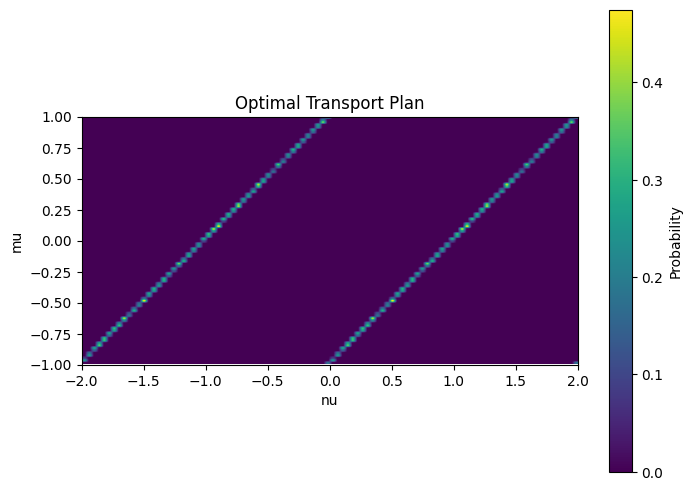

In [3]:
# Plot the optimal transport plan
plt.figure(figsize=(8, 6))
plt.imshow(P_opt, cmap='viridis', origin='lower', extent=[nu_a, nu_b, mu_a, mu_b])
plt.colorbar(label='Probability')
plt.xlabel('nu')
plt.ylabel('mu')
plt.title('Optimal Transport Plan')
plt.show()

In [4]:
# Verify that Y follows the uniform distribution on (-2, 2)
d, p_value = stats.kstest(new_y_samples, 'uniform', args=(-2, 4))
follow_law = p_value > 0.05
print("Y follows uniform distribution on (-2, 2):", follow_law)

# Compute the expected cost
expected_cost = np.mean(c(x_samples, new_y_samples))
print("Expected cost E[c(X, Y)]:", expected_cost)

# Verify the inequality
lhs = np.mean(c(x_samples, new_y_samples))
rhs = np.sqrt(np.mean((x_samples - new_y_samples)**2))
print("Inequality holds:", lhs <= rhs)

# Verify the martingale property
martingale_diff = np.mean(new_y_samples - x_samples)
print("Martingale difference:", martingale_diff)
print("Martingale difference is close to 0:", np.isclose(martingale_diff, 0, atol=0.03))

Y follows uniform distribution on (-2, 2): True
Expected cost E[c(X, Y)]: 1.004494928983112
Inequality holds: True
Martingale difference: -0.044112381248354586
Martingale difference is close to 0: False


---

In [6]:
import numpy as np

# Example discrete distributions for mu and nu
# Assume mu and nu are already normalized and have the same total mass
mu = np.array([0.4, 0.6])
nu = np.array([0.5, 0.5])

# Cost matrix based on simple supports for mu and nu
# Here, we simply use indices to represent support points, for simplicity
xi = np.array([0, 1])  # Support for mu
yj = np.array([0, 1])  # Support for nu
C = np.abs(xi[:, None] - yj)  # Cost matrix

def project_onto_C1(p, mu):
    """Project p onto C1: Marginal matching for mu."""
    return p * (mu / (p.sum(axis=1) + 1e-8))

def project_onto_C2(p, nu):
    """Project p onto C2: Marginal matching for nu."""
    return p * (nu / (p.sum(axis=0) + 1e-8))

def project_onto_martingale_constraint(p, xi, yj, mu):
    """Project p onto C2+l: Martingale constraint."""
    expected_y_per_x = np.dot(p, yj) / (mu + 1e-8)
    adjustment_factors = xi / expected_y_per_x
    adjustment_factors = np.where(np.isnan(adjustment_factors), 1, adjustment_factors)
    p_adjusted = p * adjustment_factors[:, None]
    return p_adjusted

def bregman_projection(mu, nu, xi, yj, C, max_iter=10):
    m, n = C.shape
    p = np.exp(-C)  # Initial guess
    p /= np.sum(p)  # Normalize

    for _ in range(max_iter):
        p = project_onto_C1(p, mu)
        p = project_onto_C2(p, nu)
        p = project_onto_martingale_constraint(p, xi, yj, mu)

        # Normalize p again to ensure it's a probability distribution
        p /= np.sum(p)
        
    return p

# Perform the Bregman projection
p_star = bregman_projection(mu, nu, xi, yj, C)
print("Optimal transport plan p*:")
print(p_star)

Optimal transport plan p*:
[[0.         0.        ]
 [0.50000001 0.49999999]]


C:\Users\monde\AppData\Local\Temp\ipykernel_20100\1628947140.py:25: RuntimeWarning: invalid value encountered in divide
  adjustment_factors = xi / expected_y_per_x


In [7]:
import numpy as np

def project_onto_C1(p, mu):
    """Project p onto C1: Marginal matching for mu."""
    return p * (mu / (p.sum(axis=1) + 1e-8))

def project_onto_C2(p, nu):
    """Project p onto C2: Marginal matching for nu."""
    return p * (nu / (p.sum(axis=0) + 1e-8))

def project_onto_martingale_constraint(p, xi, yj, mu):
    """Project p onto C2+l: Martingale constraint."""
    expected_y_per_x = np.dot(p, yj) / (mu + 1e-8)
    adjustment_factors = xi / expected_y_per_x
    adjustment_factors = np.where(np.isnan(adjustment_factors), 1, adjustment_factors)
    p_adjusted = p * adjustment_factors[:, None]
    return p_adjusted

def bregman_projection(mu, nu, xi, yj, C, max_iter=100):
    m, n = C.shape
    p = np.exp(-C)  # Initial guess
    p /= np.sum(p)  # Normalize
    for _ in range(max_iter):
        p = project_onto_C1(p, mu)
        p = project_onto_C2(p, nu)
        p = project_onto_martingale_constraint(p, xi, yj, mu)
        # Normalize p again to ensure it's a probability distribution
        p /= np.sum(p)
       
    return p

# Define the support and cost matrix for uniform distributions
def uniform_support(a, b, n):
    return np.linspace(a, b, n)

def cost_matrix(xi, yj):
    return np.abs(xi[:, None] - yj)

# Define the parameters for the uniform distributions
mu_a, mu_b = -1, 1
nu_a, nu_b = -2, 2
n = 100  # Number of support points for each distribution

# Generate the support points for mu and nu
xi = uniform_support(mu_a, mu_b, n)
yj = uniform_support(nu_a, nu_b, n)

# Generate the cost matrix
C = cost_matrix(xi, yj)

# Generate the uniform distributions mu and nu
mu = np.ones(n) / n
nu = np.ones(n) / n

# Perform the Bregman projection
p_star = bregman_projection(mu, nu, xi, yj, C)

print("Optimal transport plan p*:")
print(p_star)

Optimal transport plan p*:
[[2.30484434e-04 2.30484435e-04 2.30484436e-04 ... 3.11926764e-05
  3.11926763e-05 3.11926762e-05]
 [2.25750580e-04 2.25750580e-04 2.25750581e-04 ... 3.18117210e-05
  3.18117209e-05 3.18117208e-05]
 [2.21134632e-04 2.21134633e-04 2.21134633e-04 ... 3.24460853e-05
  3.24460852e-05 3.24460851e-05]
 ...
 [3.24460851e-05 3.24460852e-05 3.24460853e-05 ... 2.21134633e-04
  2.21134633e-04 2.21134632e-04]
 [3.18117208e-05 3.18117209e-05 3.18117210e-05 ... 2.25750581e-04
  2.25750580e-04 2.25750580e-04]
 [3.11926762e-05 3.11926763e-05 3.11926764e-05 ... 2.30484436e-04
  2.30484435e-04 2.30484434e-04]]


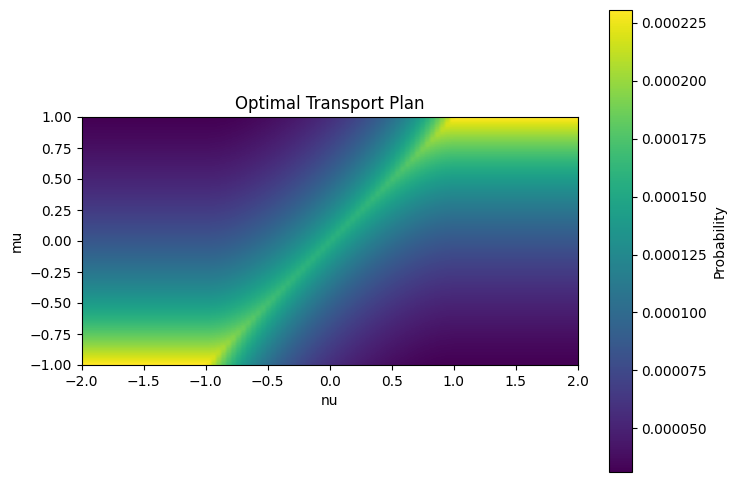

In [8]:
# Plot the optimal transport plan
plt.figure(figsize=(8, 6))
plt.imshow(p_star, cmap='viridis', origin='lower', extent=[nu_a, nu_b, mu_a, mu_b])
plt.colorbar(label='Probability')
plt.xlabel('nu')
plt.ylabel('mu')
plt.title('Optimal Transport Plan')
plt.show()

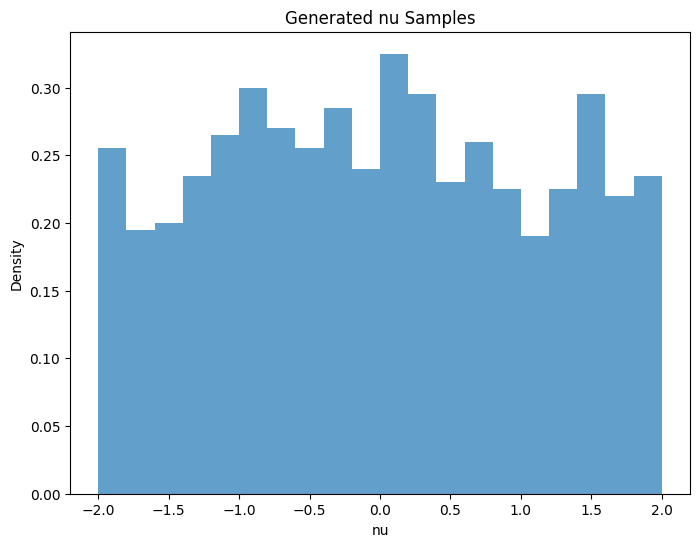

In [9]:
# Generate new nu samples using the optimal transport plan
num_samples = 1000
mu_samples = np.random.choice(xi, size=num_samples, p=mu)
nu_samples = []
for x in mu_samples:
    idx = np.where(xi == x)[0][0]
    p_row = p_star[idx] / np.sum(p_star[idx])  # Normalize the row probabilities
    nu_samples.append(np.random.choice(yj, p=p_row))
nu_samples = np.array(nu_samples)

# Plot the generated nu samples
plt.figure(figsize=(8, 6))
plt.hist(nu_samples, bins=20, density=True, alpha=0.7)
plt.xlabel('nu')
plt.ylabel('Density')
plt.title('Generated nu Samples')
plt.show()

In [10]:
# Verify that Y follows the uniform distribution on (-2, 2)
d, p_value = stats.kstest(nu_samples, 'uniform', args=(-2, 4))
follow_law = p_value > 0.05
print("Y follows uniform distribution on (-2, 2):", follow_law)

# Compute the expected cost
expected_cost = np.mean(c(mu_samples, nu_samples))
print("Expected cost E[c(X, Y)]:", expected_cost)

# Verify the inequality
lhs = np.mean(c(mu_samples, nu_samples))
rhs = np.sqrt(np.mean((mu_samples - nu_samples)**2))
print("Inequality holds:", lhs <= rhs)

# Verify the martingale property
martingale_diff = np.mean(nu_samples - mu_samples)
print("Martingale difference:", martingale_diff)
print("Martingale difference is close to 0:", np.isclose(martingale_diff, 0, atol=0.03))

Y follows uniform distribution on (-2, 2): True
Expected cost E[c(X, Y)]: 0.812989898989899
Inequality holds: True
Martingale difference: 0.006727272727272801
Martingale difference is close to 0: True
